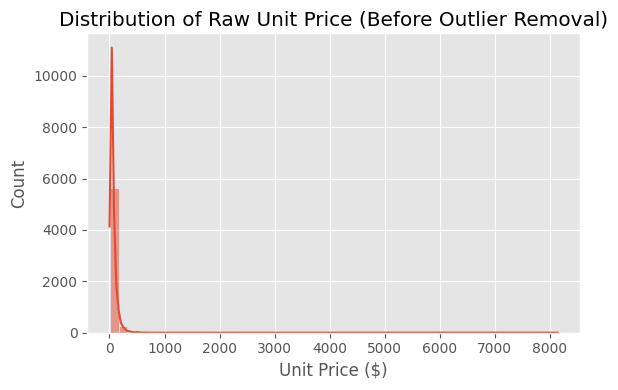

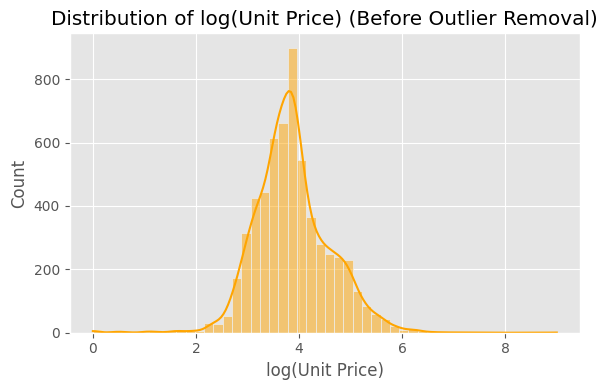


🔎 Identifying outliers using standardized residuals and leverage...
🚨 Outliers flagged: 264 / 5965
✅ Remaining observations: 5701
🚨 Total unusual observations flagged: 224
↪ Based on: |standardized residual| > 2 OR leverage > 0.0126
↪ Total rows in dataset: 5701
↪ Fraction of outliers: 3.93%

📋 Top 10 most extreme standardized residuals:
                   Item Description  log_unit_price  standard_resid  leverage
13000  AGGREGATE BASE COURSE, CLASS        6.551080        2.853394  0.006432
341        OPEN-GRADED BASE CLASS I        4.317488       -2.743021  0.005465
17325                  Subbase, CIP        4.976734        2.708393  0.003935
21193                  Subbase, CIP        2.647592       -2.696690  0.004035
23370                Aggregate Base        3.091042       -2.682875  0.005200
17951                  Subbase, CIP        2.708050       -2.675773  0.002997
13966  AGGREGATE BASE COURSE, CLASS        5.275253        2.669083  0.004779
16062   GR AGGR BASE CRS, INCL MATL

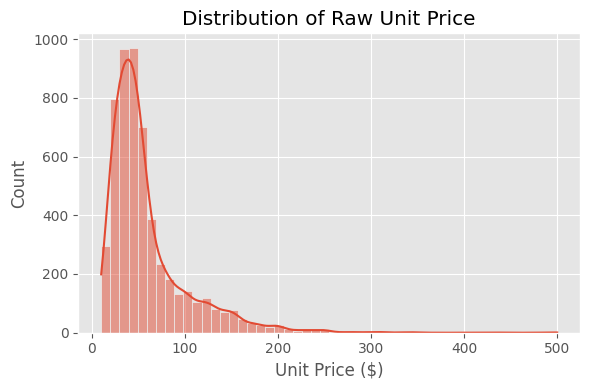

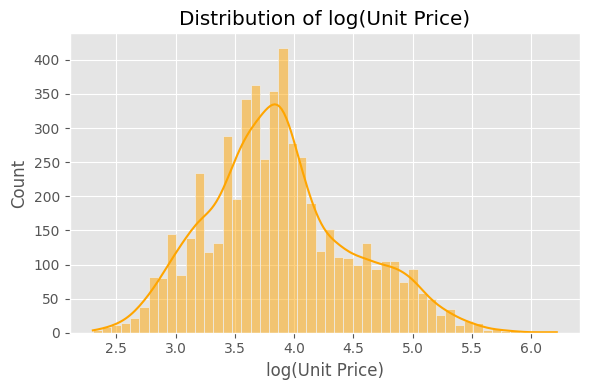


📋 Top 5 Most Expensive Unit Prices:
                   Item Description  Unit Price  Quantity Category
13566  AGGREGATE BASE COURSE, CLASS      500.00       2.0     Base
13003  AGGREGATE BASE COURSE, CLASS      490.85       5.0     Base
12992  AGGREGATE BASE COURSE, CLASS      435.00       8.0     Base
11963  AGGREGATE BASE COURSE, CLASS      350.00       8.0     Base
13750  AGGREGATE BASE COURSE, CLASS      345.00      24.0     Base


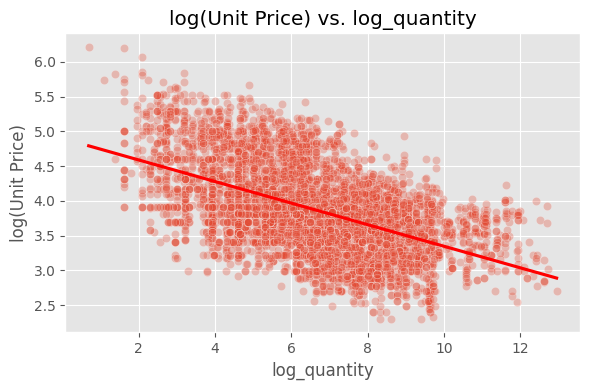

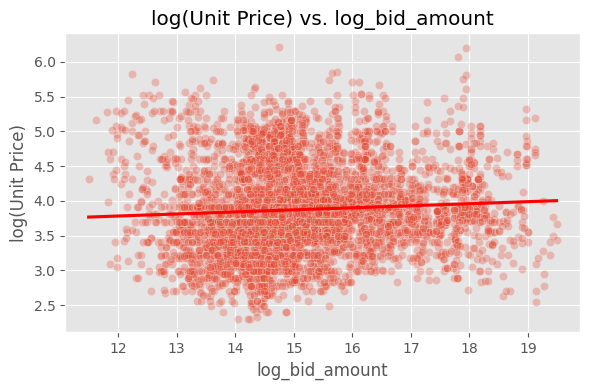

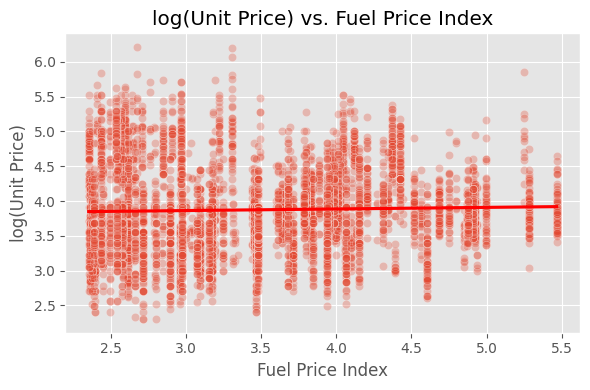

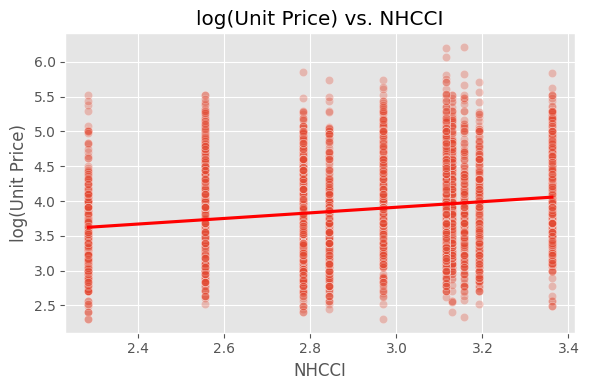

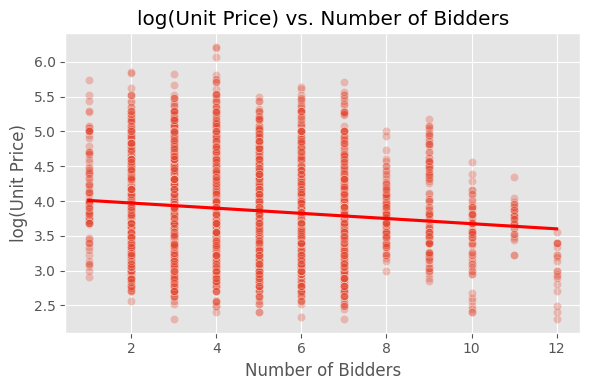

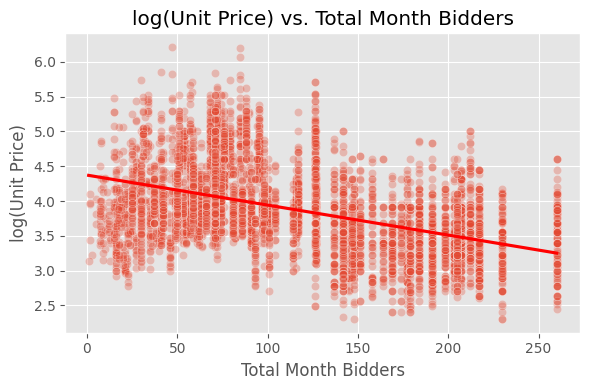

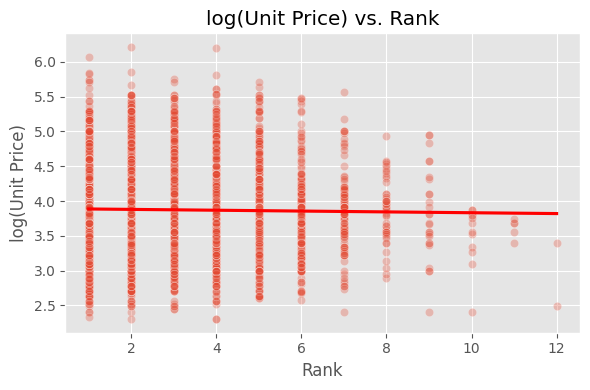

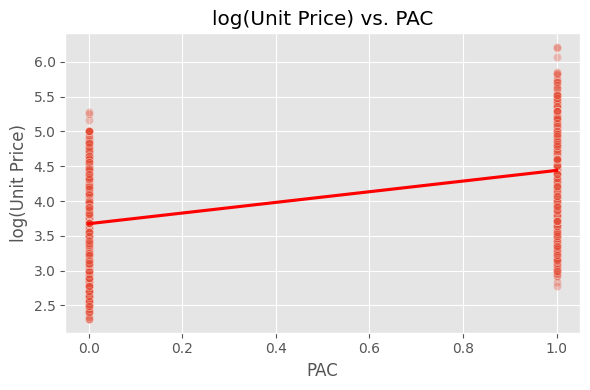

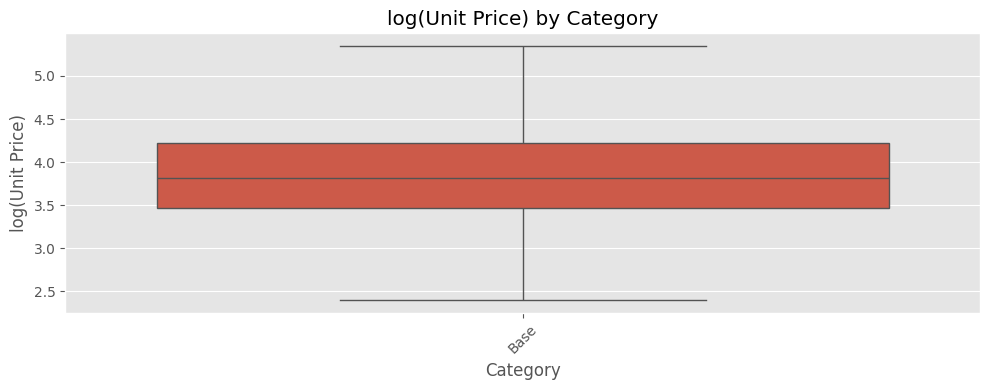

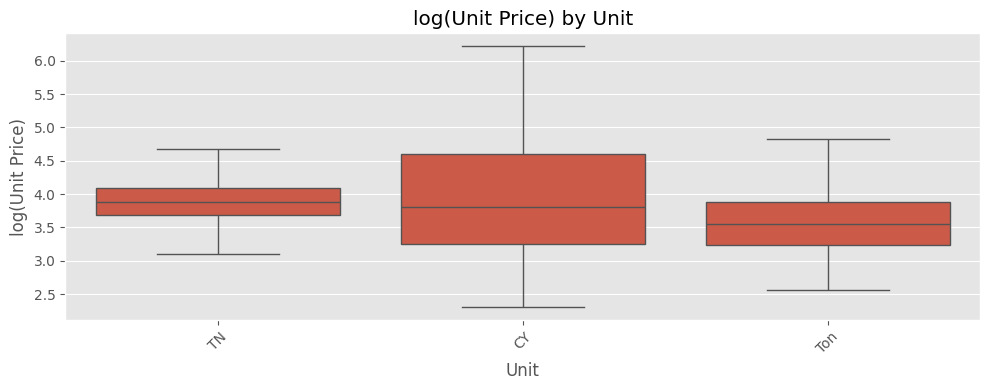

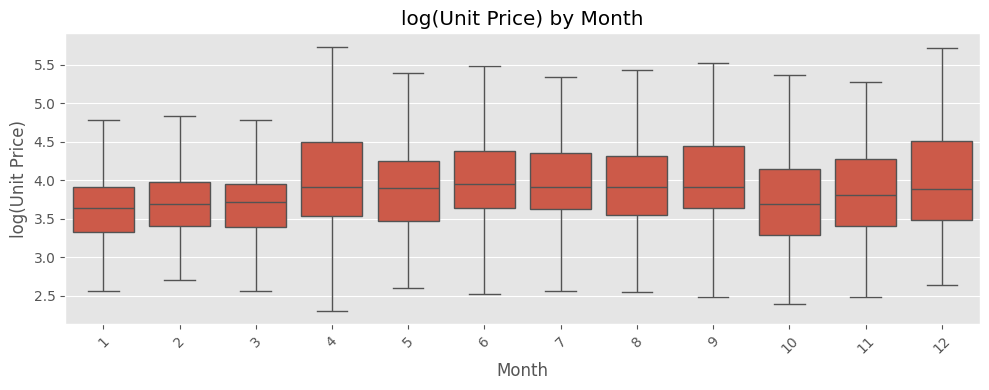

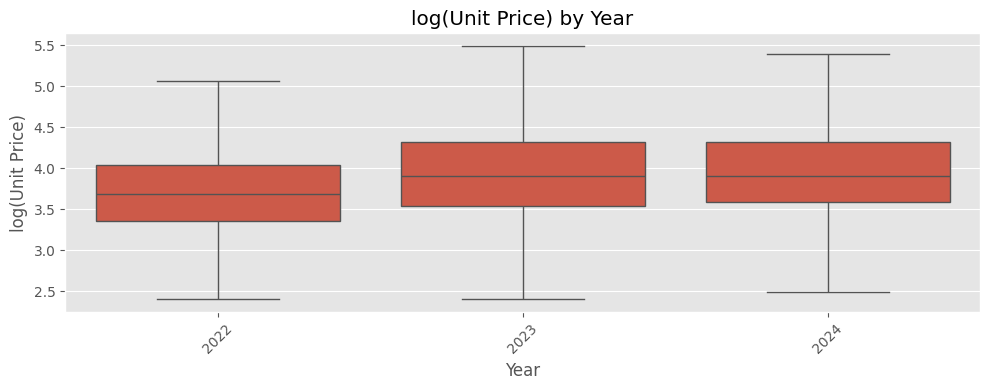


🔍 Checking for suspiciously low unit prices (log_unit_price < -4)...
Empty DataFrame
Columns: [Item Description, Unit Price, Quantity, Bid Amount, Category, log_unit_price]
Index: []

⚠️ Total observations with log_unit_price < -4: 0

📊 Variance Inflation Factors (VIF):
               Feature         VIF
0                const  366.371351
1                  PAC    1.629136
2         log_quantity    1.272714
3       log_bid_amount    1.384584
4     Fuel Price Index    1.630993
5                NHCCI    1.235303
6    Number of Bidders    1.577114
7  Total Month Bidders    2.066010
8                 Rank    1.535194
                            OLS Regression Results                            
Dep. Variable:         log_unit_price   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     484.2
Date:                Thu, 17 Jul 2025   Prob (F-statistic):   

Co-variance matrix is underdetermined. Inference will be invalid!



📋 DML Summary for CATE_logUnitPrice:
ATE: 0.112420, CI: [0.106477, 0.118363], Std: 0.220880, IQR: 0.235099, CV: 1.964773

📋 DML Summary for CATE_UnitPrice:
ATE: 10.323243, CI: [9.749660, 10.896826], Std: 21.316899, IQR: 23.573953, CV: 2.064942


Co-variance matrix is underdetermined. Inference will be invalid!


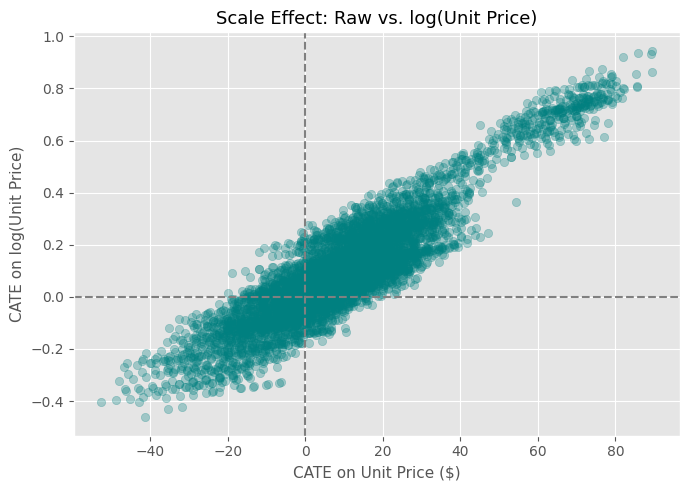

                            WLS Regression Results                            
Dep. Variable:         log_unit_price   R-squared:                       0.232
Model:                            WLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     1598.
Date:                Thu, 17 Jul 2025   Prob (F-statistic):          1.10e-305
Time:                        11:20:02   Log-Likelihood:                -4281.6
No. Observations:                5306   AIC:                             8567.
Df Residuals:                    5304   BIC:                             8580.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7442      0.008    462.876      0.0

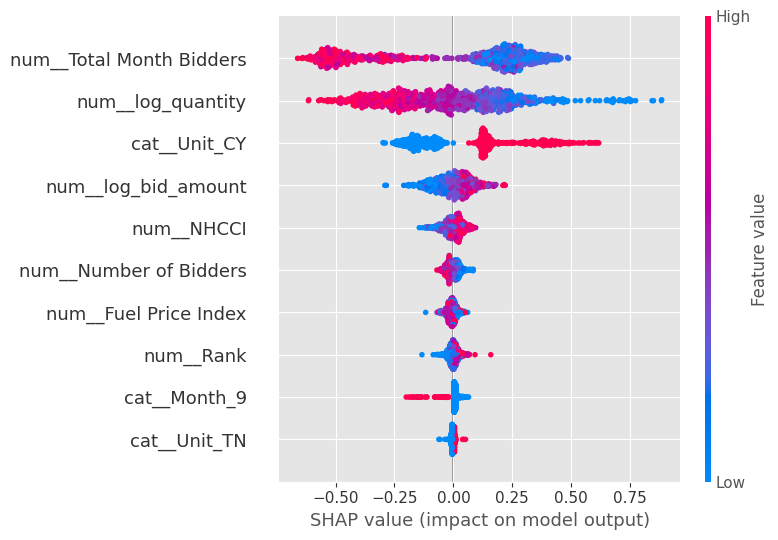


📈 SHAP (Without PAC) — unit_price


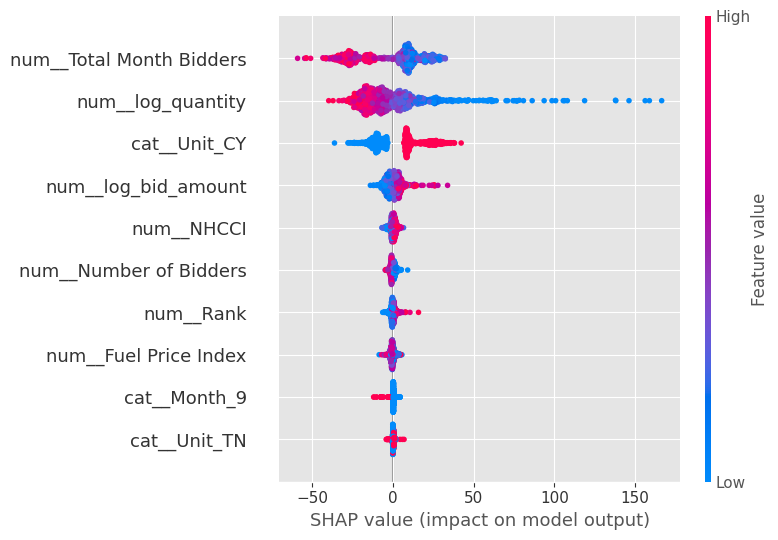


📈 SHAP (With PAC) — log_unit_price


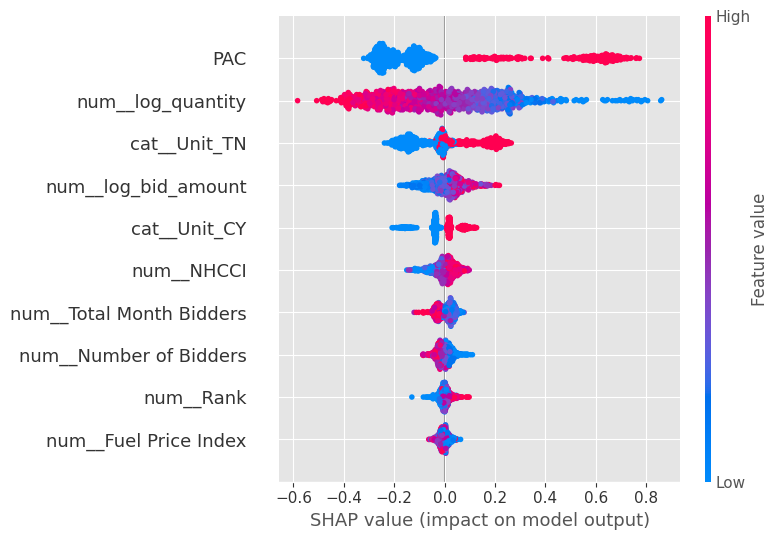


📈 SHAP (With PAC) — unit_price


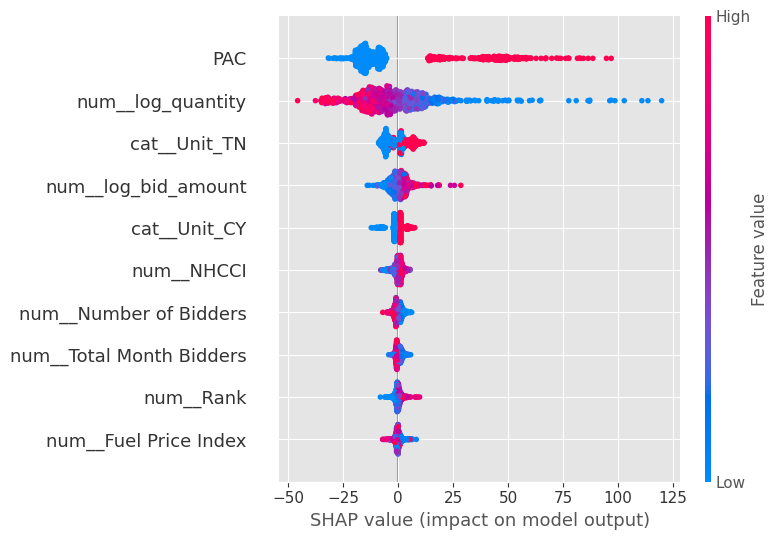


📋 PSM (Nearest Neighbor Matching) Summary:
ATT: 0.212460, CI: [0.176122, 0.248798], Std Error: 0.018540


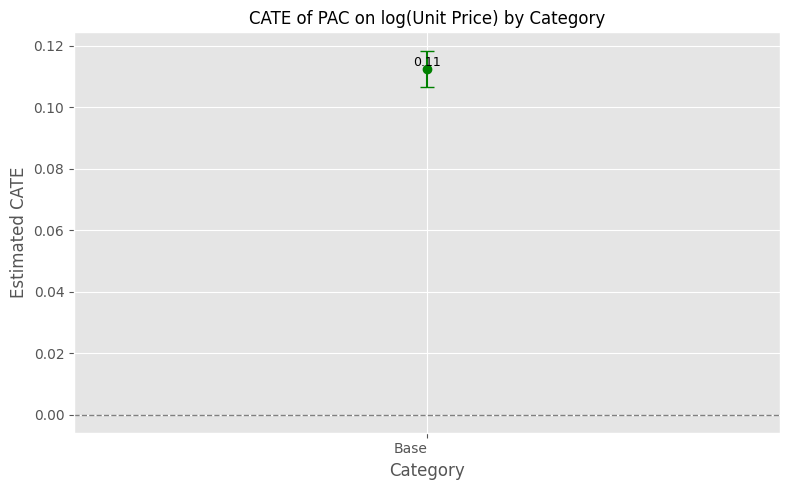

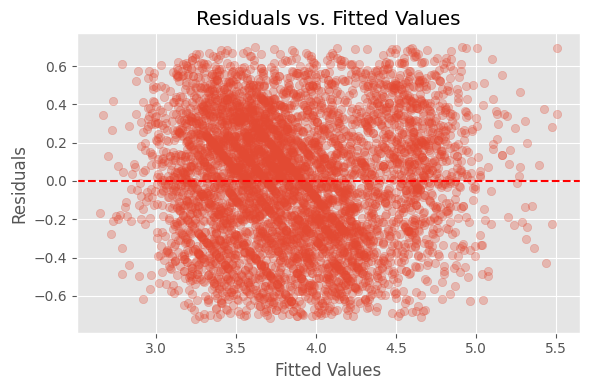

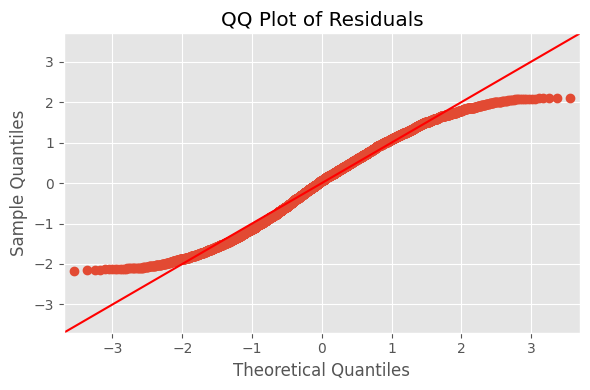


📋 Breusch–Pagan Test for Heteroskedasticity:
Statistic: 151.4030, p-value: 0.0000

📋 Cook's Distance:
156 influential observations out of 5306 (2.94%)

📋 Residual Clusters (k=3):
resid_cluster
0    2318
1    1732
2    1256
Name: count, dtype: int64

📋 ANOVA Results for OLS:
                              sum_sq      df            F         PR(>F)
C(Month)                   27.845862    11.0    22.796250   2.829650e-46
C(Year)                    23.560522     2.0   106.084112   6.753188e-46
C(Unit)                    20.582566     2.0    92.675502   2.764547e-40
PAC                        60.823757     1.0   547.732704  2.430929e-115
log_quantity              454.652671     1.0  4094.257702   0.000000e+00
log_bid_amount             53.971381     1.0   486.025395  4.117583e-103
Q('Fuel Price Index')      24.162538     1.0   217.589524   2.742842e-48
NHCCI                      11.135560     1.0   100.278422   2.138510e-23
Q('Number of Bidders')      8.558754     1.0    77.073662   2.19154

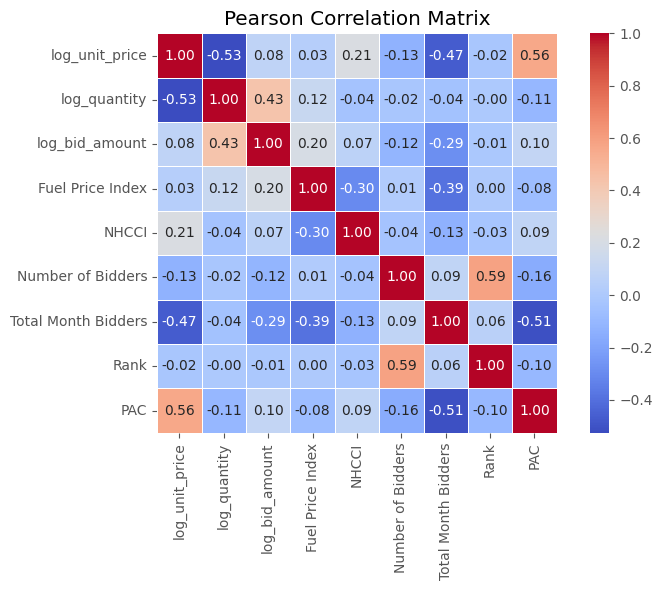

In [1]:
# === Step 0: Setup ===
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from econml.dml import LinearDML
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import NearestNeighbors
import shap

# Reproducibility
random.seed(42)
np.random.seed(42)
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
mplstyle.use('ggplot')

# === Step 1: Load Data ===
df = pd.read_csv(r"\\homes.mtu.edu\home\Desktop\Raw Data\Filtered\filtered_bidtabs_ALL.csv", low_memory=False)

# Merge Category
mapping = pd.read_csv(r"\\homes.mtu.edu\home\Desktop\Raw Data\iTEMs.csv")
mapping = mapping[['Item Description', 'Group']].drop_duplicates()
mapping.columns = ['Item Description', 'Category']
df = df.merge(mapping, on='Item Description', how='left')

# === Step 2: Clean and Preprocess ===
df['Quantity'] = pd.to_numeric(df['Quantity'].astype(str).str.replace(',', ''), errors='coerce')
df['Bid Amount'] = pd.to_numeric(df['Bid Amount'].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce')
df['Unit Price'] = pd.to_numeric(df['Unit Price'], errors='coerce')
df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce')

df.dropna(subset=['PAC', 'Fuel Price Index', 'NHCCI', 'Unit Price', 'Year', 'Rank', 'Category'], inplace=True)
for col in ['Unit Price', 'Quantity', 'Bid Amount']:
    df = df[df[col] > 0]

df = df[(df['Quantity'] > 0) & (df['Bid Amount'] > 0) & (df['Unit Price'] > 0.01)]

# Variable transformations (only the ones needed for regression)
df['log_unit_price'] = np.log(df['Unit Price'])
df['log_quantity'] = np.log(df['Quantity'])
df['log_bid_amount'] = np.log(df['Bid Amount'])

# Standardize units
unit_map = {'CUYD': 'CY', 'Cyd': 'CY', 'CY': 'CY',
            'SQYD': 'SY', 'SY': 'SY',
            'TON': 'TN', 'TN': 'TN'}
df['Unit'] = df['Unit'].map(unit_map).fillna(df['Unit'])

# Filter
df = df[~df['Category'].isin(['Borrow', 'Topsoil'])]
df = df[df['Unit'] != 'LS']
df = df[df['Category'] == 'Base']  

# Diagnostic plot BEFORE outlier removal
plt.figure(figsize=(6, 4))
sns.histplot(df['Unit Price'], kde=True, bins=50)
plt.title('Distribution of Raw Unit Price (Before Outlier Removal)')
plt.xlabel('Unit Price ($)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df['log_unit_price'], kde=True, bins=50, color='orange')
plt.title('Distribution of log(Unit Price) (Before Outlier Removal)')
plt.xlabel('log(Unit Price)')
plt.tight_layout()
plt.show()


# === Step 2C: Outlier Detection Only ===
print("\n🔎 Identifying outliers using standardized residuals and leverage...")
ols_formula = (
    "log_unit_price ~ PAC + log_quantity + log_bid_amount + Q('Fuel Price Index') + "
    "NHCCI + C(Month) + C(Year) + C(Unit)"
)
ols_model_temp = smf.ols(formula=ols_formula, data=df).fit(cov_type='HC1')
influence = ols_model_temp.get_influence()
standard_resid = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag

k = ols_model_temp.df_model + 1
n = ols_model_temp.nobs
leverage_cutoff = 3 * k / n

df['standard_resid'] = standard_resid
df['leverage'] = leverage
df['unusual'] = (np.abs(standard_resid) > 2) | (leverage > leverage_cutoff)

print(f"🚨 Outliers flagged: {df['unusual'].sum()} / {len(df)}")
df = df[~df['unusual']].copy()
print(f"✅ Remaining observations: {len(df)}")


ols_formula = (
    "log_unit_price ~ PAC + log_quantity + log_bid_amount + Q('Fuel Price Index') + "
    "NHCCI + Q('Number of Bidders') + Q('Total Month Bidders') + Q('Rank') + "
    "C(Month) + C(Year) + C(Category) + C(Unit)"
)
ols_model_temp = smf.ols(formula=ols_formula, data=df).fit(cov_type='HC1')

influence_temp = ols_model_temp.get_influence()
standard_resid_temp = influence_temp.resid_studentized_internal
leverage_temp = influence_temp.hat_matrix_diag
k_temp = ols_model_temp.df_model + 1
n_temp = ols_model_temp.nobs
leverage_cutoff_temp = 3 * k_temp / n_temp

# Flag and remove outliers
df['standard_resid'] = standard_resid_temp
df['leverage'] = leverage_temp
df['unusual'] = (np.abs(standard_resid_temp) > 2) | (leverage_temp > leverage_cutoff_temp)

total_outliers_temp = df['unusual'].sum()
print(f"🚨 Total unusual observations flagged: {total_outliers_temp}")
print(f"↪ Based on: |standardized residual| > 2 OR leverage > {leverage_cutoff_temp:.4f}")
print(f"↪ Total rows in dataset: {len(df)}")
print(f"↪ Fraction of outliers: {total_outliers_temp / len(df):.2%}")
print("\n📋 Top 10 most extreme standardized residuals:")
print(df.loc[df['unusual'], ['Item Description', 'log_unit_price', 'standard_resid', 'leverage']]
         .sort_values(by='standard_resid', key=np.abs, ascending=False).head(10))

print("\n✅ Dropping unusual observations from the dataset...")
df = df[~df['unusual']].copy()
print(f"Remaining observations after dropping outliers: {len(df)}")

# Refit OLS after outliers are removed
ols_model = smf.ols(formula=ols_formula, data=df).fit(cov_type='HC1')


# === Step 2C: Outcome & Predictor Diagnostics ===
print("\n📊 Outcome and Predictor Diagnostic Checks")

# 1. Distribution of Unit Price and log(Unit Price)
plt.figure(figsize=(6, 4))
sns.histplot(df['Unit Price'], kde=True, bins=50)
plt.title('Distribution of Raw Unit Price')
plt.xlabel('Unit Price ($)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df['log_unit_price'], kde=True, bins=50, color='orange')
plt.title('Distribution of log(Unit Price)')
plt.xlabel('log(Unit Price)')
plt.tight_layout()
plt.show()

# 2. Detect most extreme bid prices (outliers)
print("\n📋 Top 5 Most Expensive Unit Prices:")
print(df[['Item Description', 'Unit Price', 'Quantity', 'Category']].sort_values(by='Unit Price', ascending=False).head(5))

# 3. Scatterplots: log(Unit Price) vs. numerical predictors
numeric_predictors = [
    'log_quantity', 'log_bid_amount',
    'Fuel Price Index', 'NHCCI',
    'Number of Bidders', 'Total Month Bidders', 'Rank',
    'PAC'
]

for col in numeric_predictors:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=col, y='log_unit_price', alpha=0.3)
    sns.regplot(data=df, x=col, y='log_unit_price', scatter=False, color='red', ci=None)
    plt.title(f'log(Unit Price) vs. {col}')
    plt.xlabel(col)
    plt.ylabel('log(Unit Price)')
    plt.tight_layout()
    plt.show()

# 4. Boxplots: log(Unit Price) by categorical variables
categorical_predictors = ['Category', 'Unit', 'Month', 'Year']
for col in categorical_predictors:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df, x=col, y='log_unit_price', showfliers=False)
    plt.xticks(rotation=45)
    plt.title(f'log(Unit Price) by {col}')
    plt.xlabel(col)
    plt.ylabel('log(Unit Price)')
    plt.tight_layout()
    plt.show()
    

# === Step 2B (continued): Detect suspiciously low unit prices ===
print("\n🔍 Checking for suspiciously low unit prices (log_unit_price < -4)...")

# Inspect rows
suspicious_rows = df[df['log_unit_price'] < -4][
    ['Item Description', 'Unit Price', 'Quantity', 'Bid Amount', 'Category', 'log_unit_price']
].sort_values(by='Unit Price')

# Show top 10 problematic rows
print(suspicious_rows.head(10))

# Count how many total
print(f"\n⚠️ Total observations with log_unit_price < -4: {len(suspicious_rows)}")


#VIF Check (after preprocessing and before modeling) ===
# Prepare dataframe for VIF: Only numerical variables can be used
X_vif = df[['PAC', 'log_quantity', 'log_bid_amount', 'Fuel Price Index', 'NHCCI',
            'Number of Bidders', 'Total Month Bidders', 'Rank']].dropna()

# Add constant term
X_vif_const = sm.add_constant(X_vif)

# Compute VIFs
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]

print("\n📊 Variance Inflation Factors (VIF):")
print(vif_data)

# === Step 3: OLS Regression ===
ols_formula = (
    "log_unit_price ~ PAC + log_quantity + log_bid_amount + Q('Fuel Price Index') + "
    "NHCCI + Q('Number of Bidders') + Q('Total Month Bidders') + Q('Rank') + "
    "C(Month) + C(Year) + C(Category) + C(Unit)"
)

ols_model = smf.ols(formula=ols_formula, data=df).fit(cov_type='HC1')
print(ols_model.summary())

# === Step 3B: Outlier Detection Using Standardized Residuals and Leverage ===
print("\n🔎 Identifying unusual observations based on standardized residuals and leverage...")

influence = ols_model.get_influence()
standard_resid = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
k = ols_model.df_model + 1
n = ols_model.nobs
leverage_cutoff = 3 * k / n

df['standard_resid'] = standard_resid
df['leverage'] = leverage
df['unusual'] = (np.abs(standard_resid) > 2) | (leverage > leverage_cutoff)

total_outliers = df['unusual'].sum()
print(f"🚨 Total unusual observations flagged: {total_outliers}")
print(f"↪ Based on: |standardized residual| > 2 OR leverage > {leverage_cutoff:.4f}")
print(f"↪ Total rows in dataset: {len(df)}")
print(f"↪ Fraction of outliers: {total_outliers / len(df):.2%}")

print("\n📋 Top 10 most extreme standardized residuals:")
print(df.loc[df['unusual'], ['Item Description', 'log_unit_price', 'standard_resid', 'leverage']]
         .sort_values(by='standard_resid', key=np.abs, ascending=False).head(10))

print("\n✅ Dropping unusual observations from the dataset...")
df = df[~df['unusual']].copy()
print(f"Remaining observations after dropping outliers: {len(df)}")

# Refit OLS after outliers are removed
ols_model = smf.ols(formula=ols_formula, data=df).fit(cov_type='HC1')
print("\n📋 OLS Summary after Outlier Removal:")
print(ols_model.summary())

# Recalculate residuals and fitted values for updated model
influence = ols_model.get_influence()
df['standard_resid'] = influence.resid_studentized_internal
df['leverage'] = influence.hat_matrix_diag
residuals = ols_model.resid
fitted = ols_model.fittedvalues


# === Step 4: Prepare Features ===
X_cols = [
    'log_quantity', 'log_bid_amount', 'Fuel Price Index', 'NHCCI',
    'Number of Bidders', 'Total Month Bidders', 'Rank',
    'Month', 'Year', 'Category', 'Unit'
]
cat_cols = ['Month', 'Year', 'Category', 'Unit']
num_cols = [col for col in X_cols if col not in cat_cols]

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imp', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

X = preprocessor.fit_transform(df[X_cols])
X = X.toarray() if hasattr(X, 'toarray') else X
D = df['PAC'].values

# === Step 5A: DML — Unit Price ===
Y_price = df['Unit Price'].values
dml_price = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    model_t=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    discrete_treatment=True,
    cv=KFold(n_splits=2, shuffle=True, random_state=42),
    random_state=42
)
dml_price.fit(Y_price, D, X=X)
df['CATE_UnitPrice'] = dml_price.effect(X)

# === Step 5B: DML — log(Unit Price) ===
Y_log = df['log_unit_price'].values
dml_log = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    model_t=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    discrete_treatment=True,
    cv=KFold(n_splits=2, shuffle=True, random_state=42),
    random_state=42
)
dml_log.fit(Y_log, D, X=X)
df['CATE_logUnitPrice'] = dml_log.effect(X)

# === Step 5C: Summary Stats ===
for col in ['CATE_logUnitPrice', 'CATE_UnitPrice']:
    cate = df[col]
    ate = np.mean(cate)
    std = np.std(cate)
    iqr = np.percentile(cate, 75) - np.percentile(cate, 25)
    ci_low = ate - 1.96 * std / np.sqrt(len(cate))
    ci_high = ate + 1.96 * std / np.sqrt(len(cate))
    cv = std / np.abs(ate) if ate != 0 else np.nan
    print(f"\n\U0001F4CB DML Summary for {col}:")
    print(f"ATE: {ate:.6f}, CI: [{ci_low:.6f}, {ci_high:.6f}], Std: {std:.6f}, IQR: {iqr:.6f}, CV: {cv:.6f}")

# === Step 5D: Compare Raw vs Log CATEs (Scale effect visualization) ===
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(df['CATE_UnitPrice'], df['CATE_logUnitPrice'], alpha=0.3, color='teal')
ax.axhline(0, linestyle='--', color='gray')
ax.axvline(0, linestyle='--', color='gray')
ax.set_xlabel("CATE on Unit Price ($)", fontsize=11)
ax.set_ylabel("CATE on log(Unit Price)", fontsize=11)
ax.set_title("Scale Effect: Raw vs. log(Unit Price)", fontsize=13)
plt.tight_layout()
plt.show()

# === Step 6: IPW Estimation ===
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, D)
propensity_scores = ps_model.predict_proba(X)[:, 1]
df['ipw_weight'] = np.where(D == 1, 1 / propensity_scores, 1 / (1 - propensity_scores))
ipw_model = sm.WLS(df['log_unit_price'], sm.add_constant(D), weights=df['ipw_weight']).fit()
print(ipw_model.summary())

# === Step 7: SHAP Interpretation (With & Without PAC) ===

# Step 7.1 — Convert X to DataFrame with feature names
feature_names = preprocessor.get_feature_names_out()
X_df_full = pd.DataFrame(X, columns=feature_names)

# Step 7.2 — Random sample of 1000 rows (adjust size as needed)
sample_size = 1000
shap_sample_idx = np.random.choice(X_df_full.index, size=sample_size, replace=False)
X_sample_base = X_df_full.loc[shap_sample_idx].copy()
Y_log_sample = Y_log[shap_sample_idx]
Y_price_sample = Y_price[shap_sample_idx]
D_sample = D[shap_sample_idx]  # For checking PAC balance

# ✅ BONUS: Check PAC distribution in the SHAP sample
print("\n🎯 PAC distribution in SHAP sample:")
print(pd.Series(D_sample).value_counts())

# Step 7.3 — Manually add PAC as a column to SHAP input
X_sample_with_pac = X_sample_base.copy()
X_sample_with_pac['PAC'] = D_sample  # Binary 0/1

# Ensure PAC is first for visibility (optional)
cols = ['PAC'] + [col for col in X_sample_with_pac.columns if col != 'PAC']
X_sample_with_pac = X_sample_with_pac[cols]

# Drop PAC for SHAP without PAC
X_sample_no_pac = X_sample_with_pac.drop(columns=['PAC'])

# === Step 7A — SHAP Without PAC
print("\n📈 SHAP (Without PAC) — log_unit_price")
model_log_no_pac = RandomForestRegressor(random_state=42)
model_log_no_pac.fit(X_sample_no_pac, Y_log_sample)
explainer_log_no_pac = shap.TreeExplainer(model_log_no_pac)
shap_values_log_no_pac = explainer_log_no_pac.shap_values(X_sample_no_pac, check_additivity=False)
shap.summary_plot(shap_values_log_no_pac, X_sample_no_pac, max_display=10)

print("\n📈 SHAP (Without PAC) — unit_price")
model_price_no_pac = RandomForestRegressor(random_state=42)
model_price_no_pac.fit(X_sample_no_pac, Y_price_sample)
explainer_price_no_pac = shap.TreeExplainer(model_price_no_pac)
shap_values_price_no_pac = explainer_price_no_pac.shap_values(X_sample_no_pac, check_additivity=False)
shap.summary_plot(shap_values_price_no_pac, X_sample_no_pac, max_display=10)

# === Step 7B — SHAP With PAC
print("\n📈 SHAP (With PAC) — log_unit_price")
model_log_with_pac = RandomForestRegressor(random_state=42)
model_log_with_pac.fit(X_sample_with_pac, Y_log_sample)
explainer_log_with_pac = shap.TreeExplainer(model_log_with_pac)
shap_values_log_with_pac = explainer_log_with_pac.shap_values(X_sample_with_pac, check_additivity=False)
shap.summary_plot(shap_values_log_with_pac, X_sample_with_pac, max_display=10)

print("\n📈 SHAP (With PAC) — unit_price")
model_price_with_pac = RandomForestRegressor(random_state=42)
model_price_with_pac.fit(X_sample_with_pac, Y_price_sample)
explainer_price_with_pac = shap.TreeExplainer(model_price_with_pac)
shap_values_price_with_pac = explainer_price_with_pac.shap_values(X_sample_with_pac, check_additivity=False)
shap.summary_plot(shap_values_price_with_pac, X_sample_with_pac, max_display=10)


# === Step 8: PSM Estimation (ATT) ===
df_psm = df.copy()
df_psm['pscore'] = propensity_scores

treated = df_psm[df_psm['PAC'] == 1].reset_index(drop=True)
control = df_psm[df_psm['PAC'] == 0].reset_index(drop=True)

nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control['pscore'].values.reshape(-1, 1))
dists, indices = nn.kneighbors(treated['pscore'].values.reshape(-1, 1))

matched_control = control.iloc[indices.flatten()].reset_index(drop=True)
att = (treated['log_unit_price'].values - matched_control['log_unit_price'].values).mean()
se = (treated['log_unit_price'].values - matched_control['log_unit_price'].values).std() / np.sqrt(len(treated))
ci_low = att - 1.96 * se
ci_high = att + 1.96 * se

print("\n\U0001F4CB PSM (Nearest Neighbor Matching) Summary:")
print(f"ATT: {att:.6f}, CI: [{ci_low:.6f}, {ci_high:.6f}], Std Error: {se:.6f}")

# === Step 9: Enhanced CATE Heterogeneity Plot by Category ===

# Ensure required columns exist
if 'Category' in df.columns and 'CATE_logUnitPrice' in df.columns:
    # Aggregate CATE stats
    cate_by_group = df.groupby('Category')['CATE_logUnitPrice'].agg(['mean', 'count', 'std'])
    cate_by_group['sem'] = cate_by_group['std'] / np.sqrt(cate_by_group['count'])
    cate_by_group['ci_low'] = cate_by_group['mean'] - 1.96 * cate_by_group['sem']
    cate_by_group['ci_high'] = cate_by_group['mean'] + 1.96 * cate_by_group['sem']
    
    # Sort by CATE mean
    cate_by_group = cate_by_group.sort_values('mean', ascending=False)

    # Determine significance (CI does NOT include zero)
    cate_by_group['significant'] = ~((cate_by_group['ci_low'] <= 0) & (cate_by_group['ci_high'] >= 0))
    colors = ['green' if sig else 'gray' for sig in cate_by_group['significant']]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)

    for i, (cat, row) in enumerate(cate_by_group.iterrows()):
        ax.errorbar(i, row['mean'], yerr=1.96 * row['sem'], fmt='o', color=colors[i], capsize=5)
        ax.text(i, row['mean'], f"{row['mean']:.2f}", ha='center', va='bottom', fontsize=9)

    ax.set_xticks(range(len(cate_by_group)))
    ax.set_xticklabels(cate_by_group.index, rotation=0, ha='right')
    ax.set_title('CATE of PAC on log(Unit Price) by Category', fontsize=12)
    ax.set_ylabel('Estimated CATE')
    ax.set_xlabel('Category')
    plt.tight_layout()
    plt.show()
    
    
# === Step 10: Residual Diagnostics ===
# Residuals vs. Fitted and QQ plot to check assumptions of linear regression
import scipy.stats as stats

# Extract residuals and fitted values
residuals = ols_model.resid
fitted = ols_model.fittedvalues

# Residuals vs. Fitted Plot
plt.figure(figsize=(6, 4))
plt.scatter(fitted, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.tight_layout()
plt.show()

# QQ Plot
fig = plt.figure(figsize=(6, 4))
sm.qqplot(residuals, line='45', fit=True, ax=fig.add_subplot(111))
plt.title('QQ Plot of Residuals')
plt.tight_layout()
plt.show()

# === Step 10B: Residual Clustering and Influence Diagnostics ===

from statsmodels.stats.diagnostic import het_breuschpagan

# (a) Breusch–Pagan Test for Heteroskedasticity
exog = ols_model.model.exog
bp_test = het_breuschpagan(residuals, exog)
print("\n📋 Breusch–Pagan Test for Heteroskedasticity:")
print(f"Statistic: {bp_test[0]:.4f}, p-value: {bp_test[1]:.4f}")

# (b) Cook's Distance to detect influential observations
influence = ols_model.get_influence()
(c, p) = influence.cooks_distance
n = len(df)
high_influence_count = sum(c > 4/n)
print(f"\n📋 Cook's Distance:")
print(f"{high_influence_count} influential observations out of {n} ({100*high_influence_count/n:.2f}%)")

# (c) Optional: Clustering of Residuals (KMeans)
from sklearn.cluster import KMeans

cluster_input = np.column_stack((fitted, residuals))
kmeans = KMeans(n_clusters=3, random_state=42)
df['resid_cluster'] = kmeans.fit_predict(cluster_input)

# Count of data points in each residual cluster
print("\n📋 Residual Clusters (k=3):")
print(df['resid_cluster'].value_counts().sort_index())


# === Step 11: ANOVA Test for OLS ===
from statsmodels.stats.anova import anova_lm

# Check if 'Unit' has more than one category
if df['Unit'].nunique() > 1:
    anova_formula = (
        "log_unit_price ~ PAC + log_quantity + log_bid_amount + "
        "Q('Fuel Price Index') + NHCCI + Q('Number of Bidders') + Q('Total Month Bidders') + Rank + "
        "C(Month) + C(Year) + C(Unit)"
    )
else:
    anova_formula = (
        "log_unit_price ~ PAC + log_quantity + log_bid_amount + "
        "Q('Fuel Price Index') + NHCCI + Q('Number of Bidders') + Q('Total Month Bidders') + Rank + "
        "C(Month) + C(Year)"
    )

anova_model = smf.ols(formula=anova_formula, data=df).fit()
anova_results = anova_lm(anova_model, typ=2)
print("\n📋 ANOVA Results for OLS:")
print(anova_results)

# === Step 12: Pearson Correlation Matrix ===
corr_cols = [
    'log_unit_price', 'log_quantity', 'log_bid_amount',
    'Fuel Price Index', 'NHCCI', 'Number of Bidders',
    'Total Month Bidders', 'Rank',
    'PAC'
]

# Drop rows with NaN in selected columns to avoid NaNs in the correlation matrix
df_corr = df[corr_cols].dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True,
            linewidths=0.5, linecolor='white')
plt.title('Pearson Correlation Matrix')
plt.tight_layout()
plt.show()

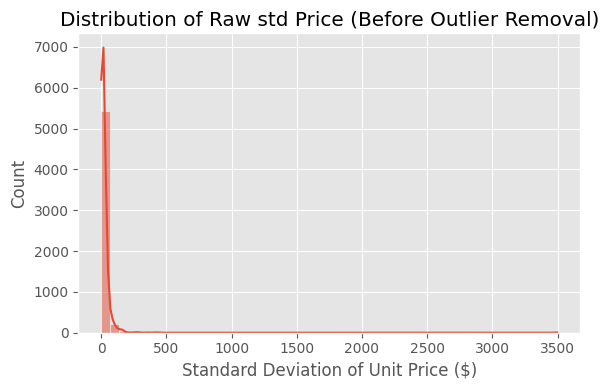

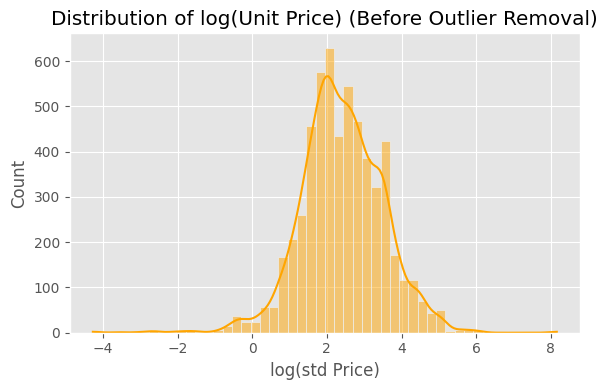


🔎 Identifying outliers using standardized residuals and leverage...
🚨 Outliers flagged: 267 / 5717
✅ Remaining observations: 5450
🚨 Total unusual observations flagged: 302
↪ Based on: |standardized residual| > 2 OR leverage > 0.0132
↪ Total rows in dataset: 5450
↪ Fraction of outliers: 5.54%

📋 Top 10 most extreme standardized residuals:
                  Item Description  log_std_price  standard_resid  leverage
18275                 Subbase, CIP       0.123102       -2.691618  0.005320
14549  GR AGGR BASE CRS, INCL MATL       3.554147        2.664724  0.004106
156       OPEN-GRADED BASE CLASS I       1.599388       -2.662955  0.006101
14550  GR AGGR BASE CRS, INCL MATL       3.554147        2.661011  0.003760
155       OPEN-GRADED BASE CLASS I       1.599388       -2.656608  0.006120
14551  GR AGGR BASE CRS, INCL MATL       3.554147        2.650214  0.003582
18274                 Subbase, CIP       0.123102       -2.647887  0.005365
14552  GR AGGR BASE CRS, INCL MATL       3.554147  

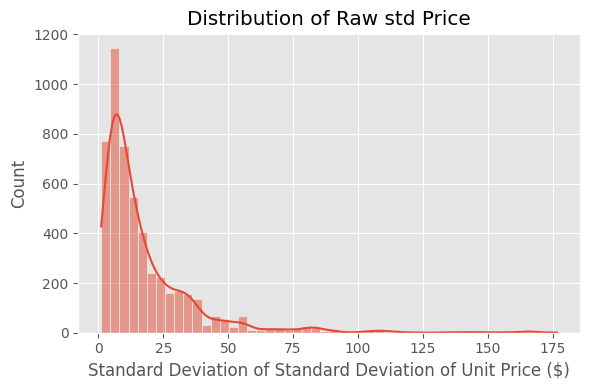

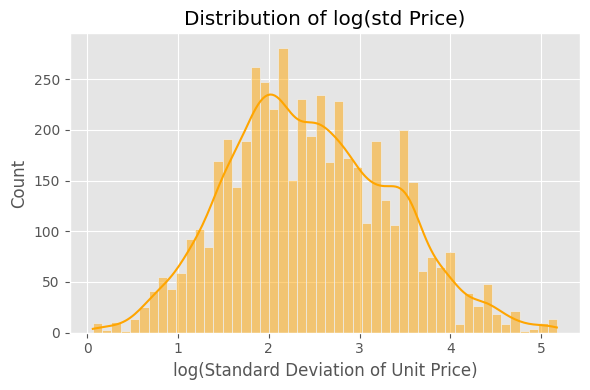


📋 Top 5 Most Expensive Unit Prices:
                   Item Description  std_price  Quantity Category
13632  AGGREGATE BASE COURSE, CLASS    176.777      12.0     Base
13633  AGGREGATE BASE COURSE, CLASS    176.777      12.0     Base
12985  AGGREGATE BASE COURSE, CLASS    165.652      17.0     Base
13003  AGGREGATE BASE COURSE, CLASS    165.652       5.0     Base
13002  AGGREGATE BASE COURSE, CLASS    165.652       5.0     Base


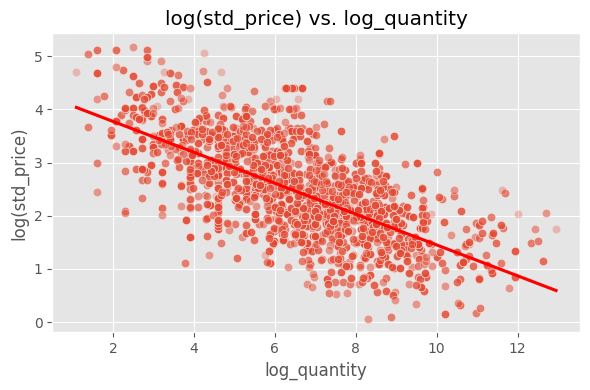

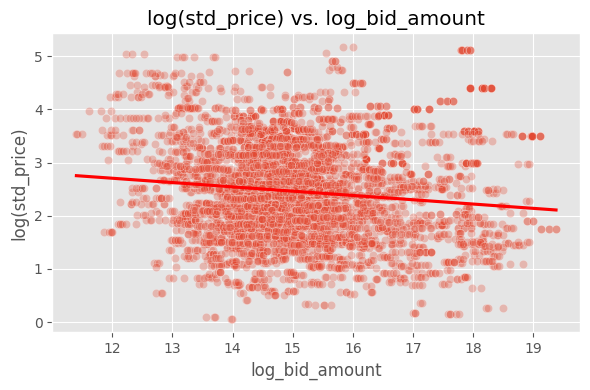

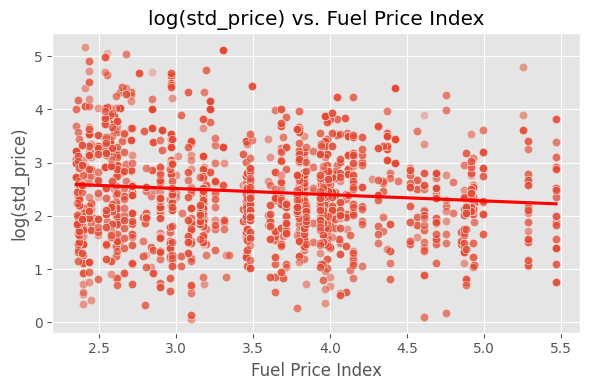

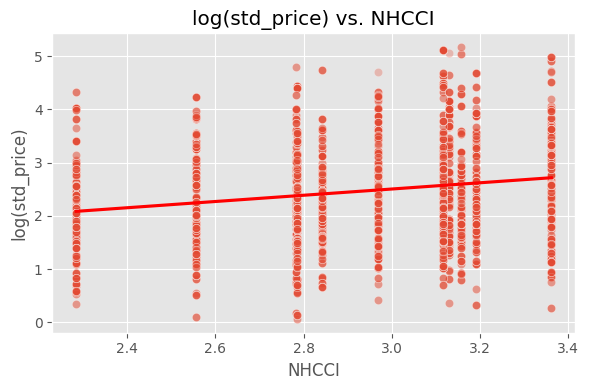

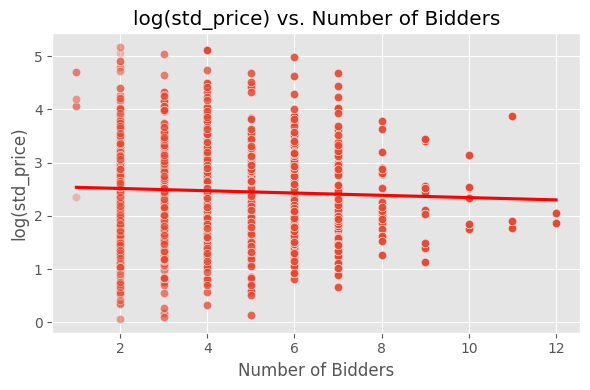

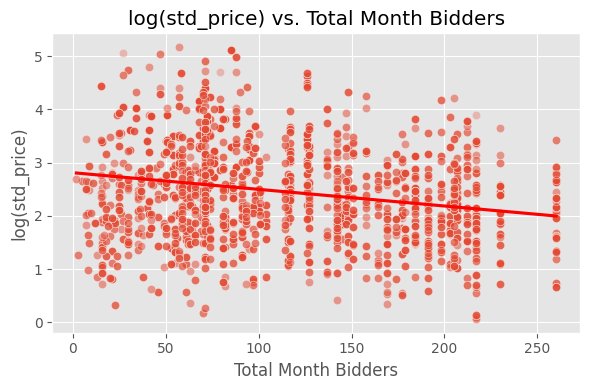

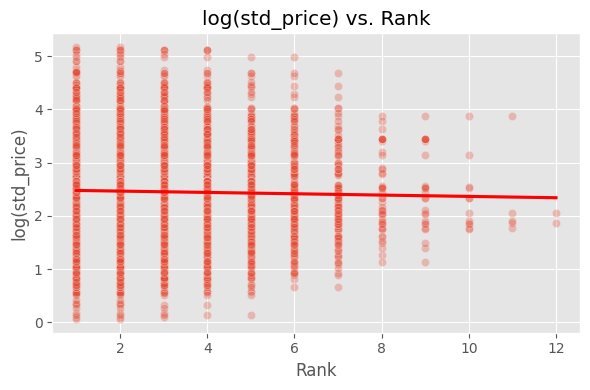

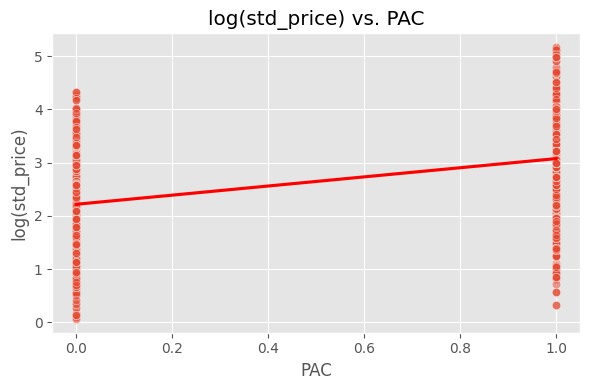

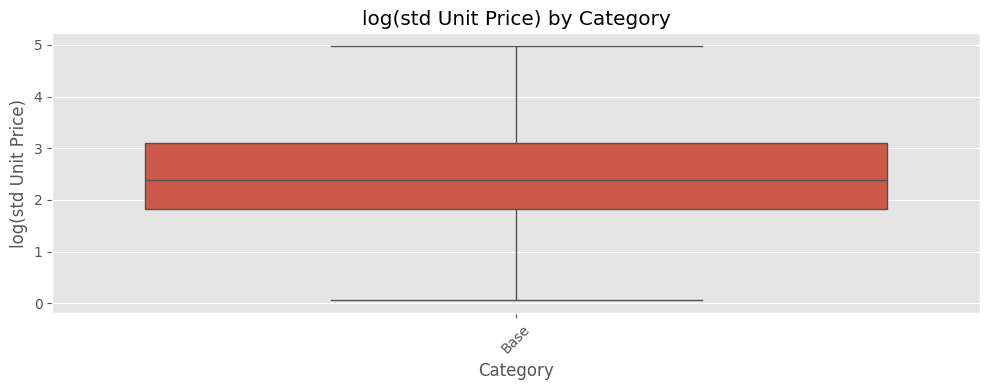

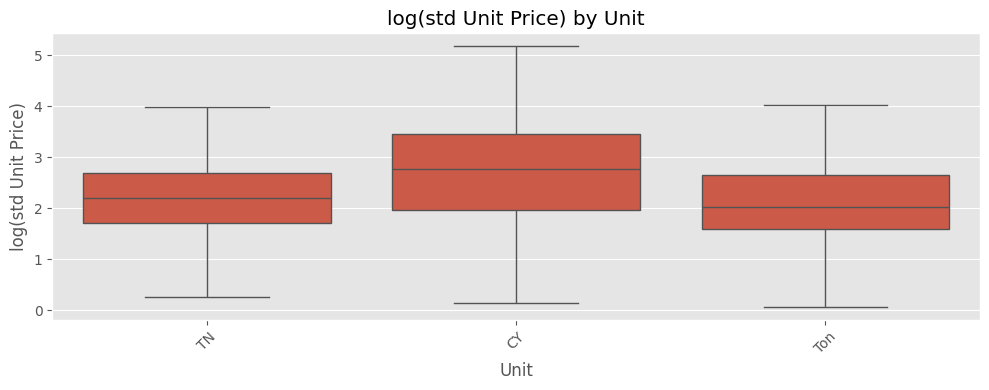

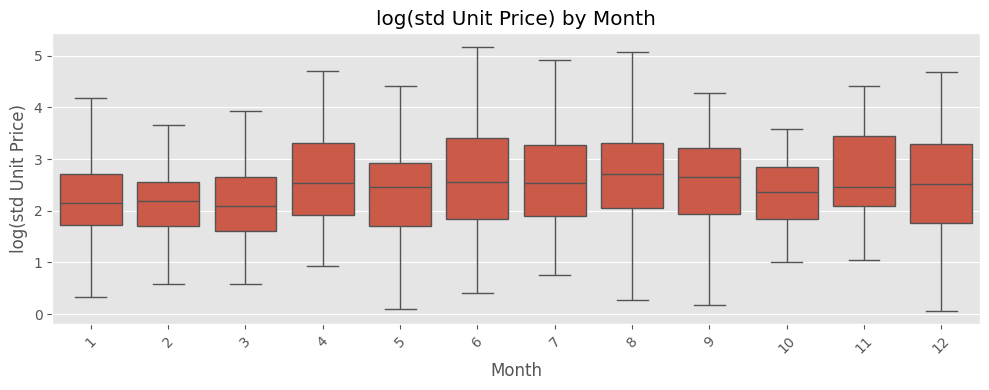

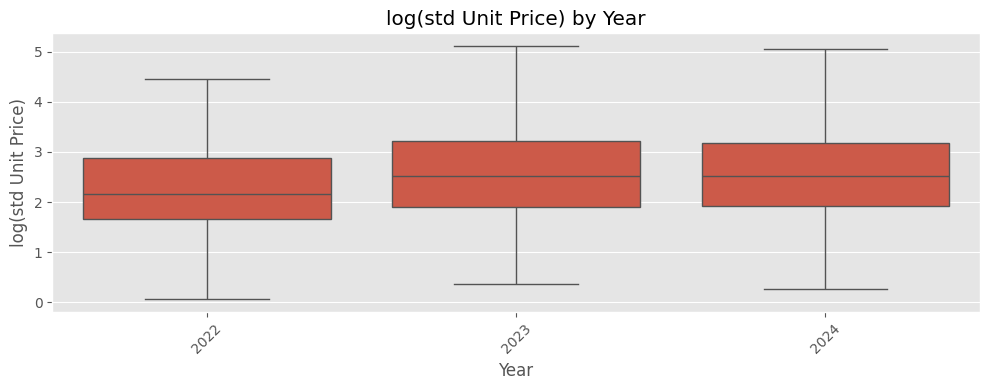


🔍 Checking for suspiciously low std prices (log_std_price < -4)...
Empty DataFrame
Columns: [Item Description, std_price, Quantity, Bid Amount, Category, log_std_price]
Index: []

⚠️ Total observations with log_std_price < -4: 0

📊 Variance Inflation Factors (VIF):
               Feature         VIF
0                const  372.161927
1                  PAC    1.679049
2         log_quantity    1.285506
3       log_bid_amount    1.395682
4     Fuel Price Index    1.653179
5                NHCCI    1.240843
6    Number of Bidders    1.494097
7  Total Month Bidders    2.090158
8                 Rank    1.449744
                            OLS Regression Results                            
Dep. Variable:          log_std_price   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     388.5
Date:                Thu, 17 Jul 2025   Prob (F-statistic):        

Co-variance matrix is underdetermined. Inference will be invalid!



📋 DML Summary for CATE_logStdPrice:
ATE: 0.574039, CI: [0.547213, 0.600865], Std: 0.963130, IQR: 0.798636, CV: 1.677812

📋 DML Summary for CATE_StdPrice:
ATE: 13.272320, CI: [12.800863, 13.743776], Std: 16.926838, IQR: 18.070362, CV: 1.275349


Co-variance matrix is underdetermined. Inference will be invalid!


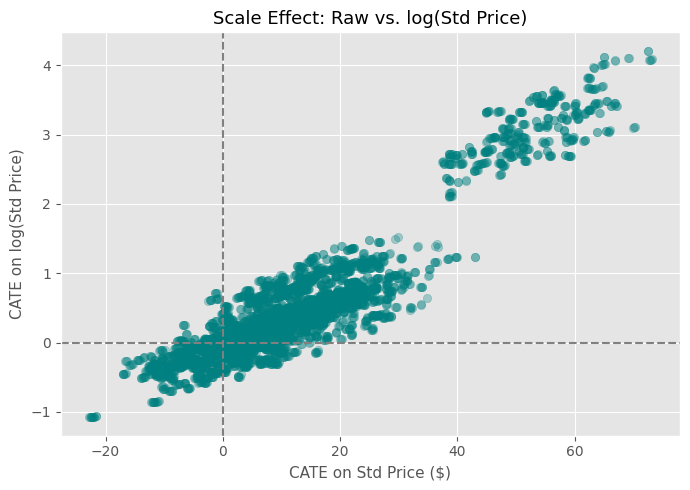

                            WLS Regression Results                            
Dep. Variable:          log_std_price   R-squared:                       0.140
Model:                            WLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     805.9
Date:                Thu, 17 Jul 2025   Prob (F-statistic):          2.21e-164
Time:                        11:22:14   Log-Likelihood:                -6417.9
No. Observations:                4952   AIC:                         1.284e+04
Df Residuals:                    4950   BIC:                         1.285e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2638      0.013    180.591      0.0

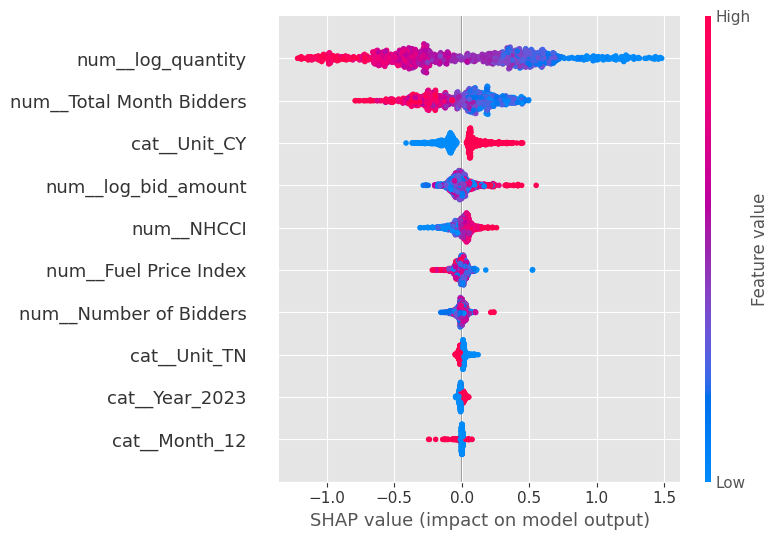


📈 SHAP (Without PAC) — std_price


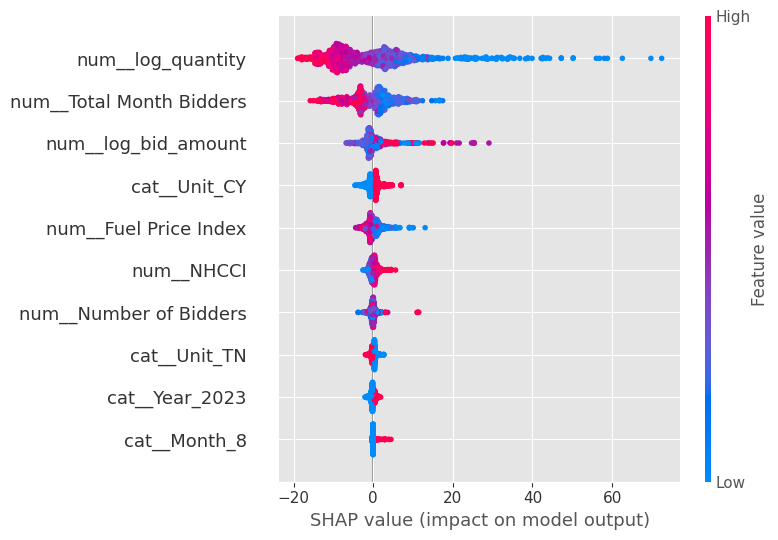


📈 SHAP (With PAC) — log_std_price


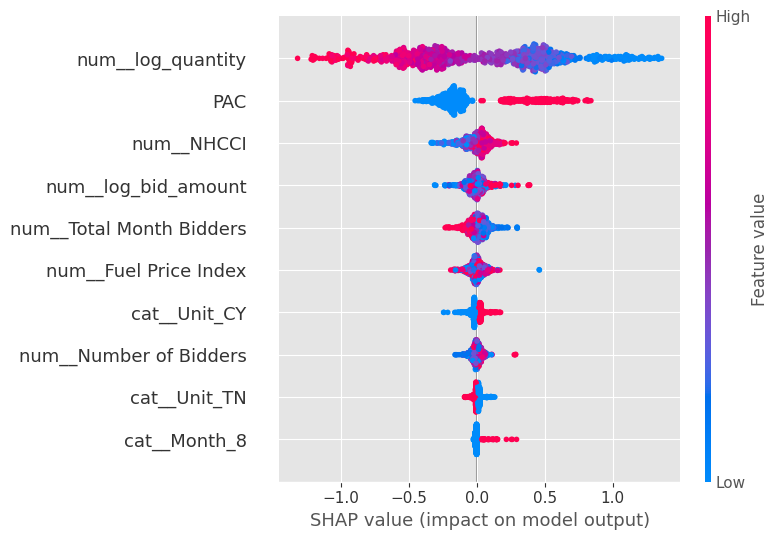


📈 SHAP (With PAC) — std_price


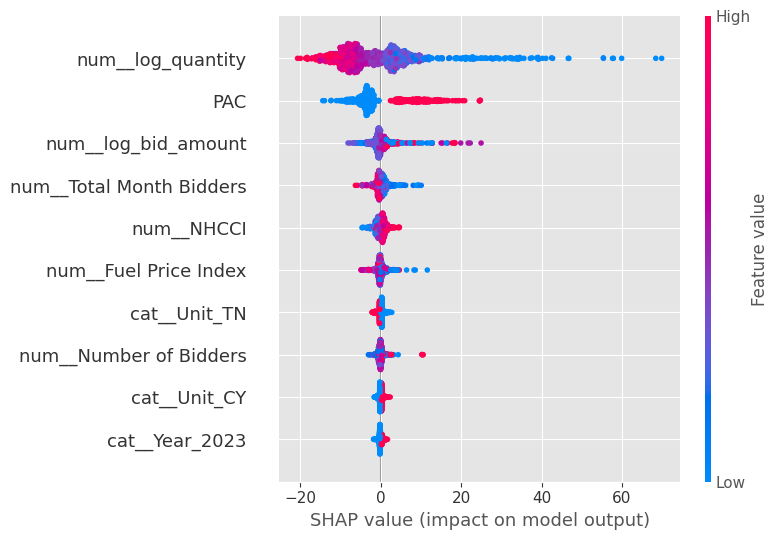


📋 PSM (Nearest Neighbor Matching) Summary:
ATT: 0.944891, CI: [0.873967, 1.015816], Std Error: 0.036186


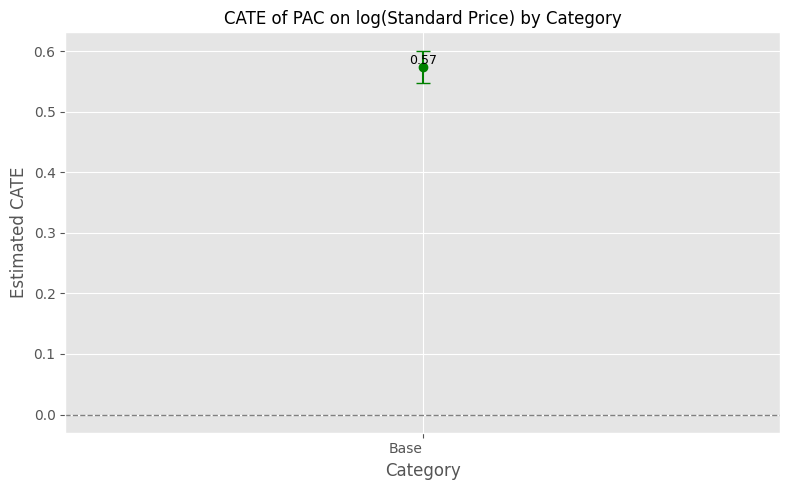

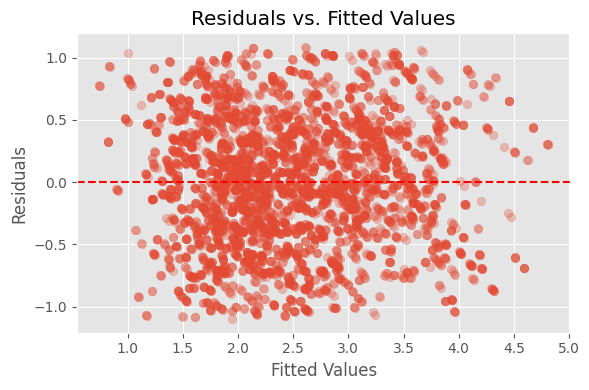

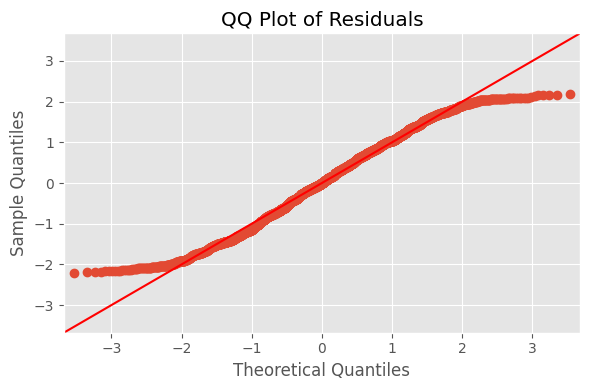


📋 Breusch–Pagan Test for Heteroskedasticity:
Statistic: 163.1780, p-value: 0.0000

📋 Cook's Distance:
140 influential observations out of 4952 (2.83%)

📋 Residual Clusters (k=3):
resid_cluster
0    1616
1    1637
2    1699
Name: count, dtype: int64

📋 ANOVA Results for OLS:
                               sum_sq      df            F        PR(>F)
C(Month)                    25.904912    11.0     9.489651  3.797536e-17
C(Year)                      8.373991     2.0    16.871874  4.984376e-08
C(Unit)                     80.304080     2.0   161.796239  8.780823e-69
PAC                         38.540025     1.0   155.300480  4.052406e-35
log_quantity              1311.012771     1.0  5282.843314  0.000000e+00
log_bid_amount              62.110685     1.0   250.280567  5.001316e-55
Q('Fuel Price Index')        7.434667     1.0    29.958657  4.632156e-08
NHCCI                        0.334069     1.0     1.346160  2.460068e-01
Q('Number of Bidders')       1.505819     1.0     6.067831  1.38005

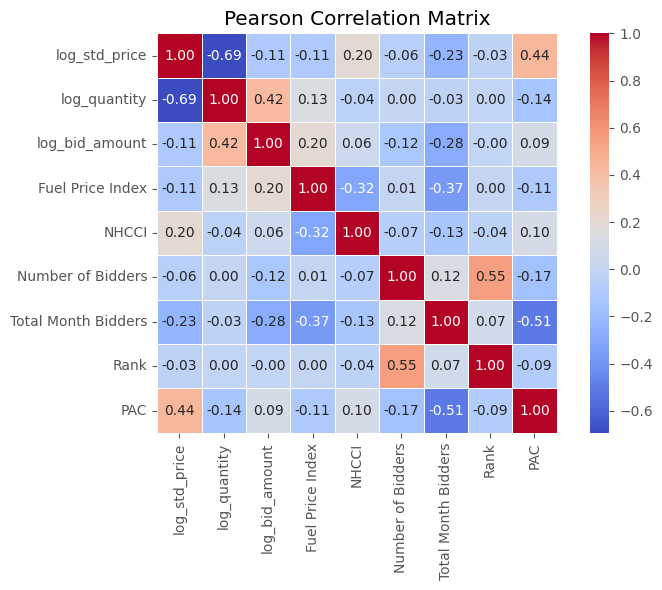

In [1]:
# === Step 0: Setup ===
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from econml.dml import LinearDML
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import NearestNeighbors
import shap

# Reproducibility
random.seed(42)
np.random.seed(42)
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
mplstyle.use('ggplot')

# === Step 1: Load Data ===
df = pd.read_csv(r"\\homes.mtu.edu\home\Desktop\Raw Data\Filtered\filtered_bidtabs_ALL.csv", low_memory=False)

# Merge Category
mapping = pd.read_csv(r"\\homes.mtu.edu\home\Desktop\Raw Data\iTEMs.csv")
mapping = mapping[['Item Description', 'Group']].drop_duplicates()
mapping.columns = ['Item Description', 'Category']
df = df.merge(mapping, on='Item Description', how='left')




# === Step 2: Clean and Preprocess ===
df['Quantity'] = pd.to_numeric(df['Quantity'].astype(str).str.replace(',', ''), errors='coerce')
df['Bid Amount'] = pd.to_numeric(df['Bid Amount'].astype(str).str.replace(r'[$,]', '', regex=True), errors='coerce')
df['Unit Price'] = pd.to_numeric(df['Unit Price'], errors='coerce')
df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce')

df.dropna(subset=['PAC', 'Fuel Price Index', 'NHCCI', 'Unit Price', 'Year', 'Rank', 'Category'], inplace=True)
for col in ['Unit Price', 'Quantity', 'Bid Amount']:
    df = df[df[col] > 0]

df = df[(df['Quantity'] > 0) & (df['Bid Amount'] > 0) & (df['std_price'] > 0.01)]


# Variable transformations
df['log_std_price'] = np.log(df['std_price'])
df['log_quantity'] = np.log(df['Quantity'])
df['log_bid_amount'] = np.log(df['Bid Amount'])


# Standardize units
unit_map = {'CUYD': 'CY', 'Cyd': 'CY', 'CY': 'CY',
            'SQYD': 'SY', 'SY': 'SY',
            'TON': 'TN', 'TN': 'TN'}
df['Unit'] = df['Unit'].map(unit_map).fillna(df['Unit'])

# Filter
df = df[~df['Category'].isin(['Borrow', 'Topsoil'])]
df = df[df['Unit'] != 'LS']
df = df[df['Category'] == 'Base']  

# Diagnostic plot BEFORE outlier removal
plt.figure(figsize=(6, 4))
sns.histplot(df['std_price'], kde=True, bins=50)
plt.title('Distribution of Raw std Price (Before Outlier Removal)')
plt.xlabel('Standard Deviation of Unit Price ($)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df['log_std_price'], kde=True, bins=50, color='orange')
plt.title('Distribution of log(Unit Price) (Before Outlier Removal)')
plt.xlabel('log(std Price)')
plt.tight_layout()
plt.show()





# === Step 2C: Outlier Detection Only ===
print("\n🔎 Identifying outliers using standardized residuals and leverage...")
ols_formula = (
    "log_std_price ~ PAC + log_quantity + log_bid_amount + Q('Fuel Price Index') + "
    "NHCCI + C(Month) + C(Year) + C(Unit)"
)
ols_model_temp = smf.ols(formula=ols_formula, data=df).fit(cov_type='HC1')
influence = ols_model_temp.get_influence()
standard_resid = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag

k = ols_model_temp.df_model + 1
n = ols_model_temp.nobs
leverage_cutoff = 3 * k / n

df['standard_resid'] = standard_resid
df['leverage'] = leverage
df['unusual'] = (np.abs(standard_resid) > 2) | (leverage > leverage_cutoff)

print(f"🚨 Outliers flagged: {df['unusual'].sum()} / {len(df)}")
df = df[~df['unusual']].copy()
print(f"✅ Remaining observations: {len(df)}")


ols_formula = (
    "log_std_price ~ PAC + log_quantity + log_bid_amount + Q('Fuel Price Index') + "
    "NHCCI + Q('Number of Bidders') + Q('Total Month Bidders') + Q('Rank') + "
    "C(Month) + C(Year) + C(Category) + C(Unit)"
)
ols_model_temp = smf.ols(formula=ols_formula, data=df).fit(cov_type='HC1')

influence_temp = ols_model_temp.get_influence()
standard_resid_temp = influence_temp.resid_studentized_internal
leverage_temp = influence_temp.hat_matrix_diag
k_temp = ols_model_temp.df_model + 1
n_temp = ols_model_temp.nobs
leverage_cutoff_temp = 3 * k_temp / n_temp

# Flag and remove outliers
df['standard_resid'] = standard_resid_temp
df['leverage'] = leverage_temp
df['unusual'] = (np.abs(standard_resid_temp) > 2) | (leverage_temp > leverage_cutoff_temp)

total_outliers_temp = df['unusual'].sum()
print(f"🚨 Total unusual observations flagged: {total_outliers_temp}")
print(f"↪ Based on: |standardized residual| > 2 OR leverage > {leverage_cutoff_temp:.4f}")
print(f"↪ Total rows in dataset: {len(df)}")
print(f"↪ Fraction of outliers: {total_outliers_temp / len(df):.2%}")
print("\n📋 Top 10 most extreme standardized residuals:")
print(df.loc[df['unusual'], ['Item Description', 'log_std_price', 'standard_resid', 'leverage']]
         .sort_values(by='standard_resid', key=np.abs, ascending=False).head(10))

print("\n✅ Dropping unusual observations from the dataset...")
df = df[~df['unusual']].copy()
print(f"Remaining observations after dropping outliers: {len(df)}")

# Refit OLS after outliers are removed
ols_model = smf.ols(formula=ols_formula, data=df).fit(cov_type='HC1')




# === Step 2C: Outcome & Predictor Diagnostics ===
print("\n📊 Outcome and Predictor Diagnostic Checks")

# 1. Distribution of Unit Price and log(std Price)
plt.figure(figsize=(6, 4))
sns.histplot(df['std_price'], kde=True, bins=50)
plt.title('Distribution of Raw std Price')
plt.xlabel('Standard Deviation of Standard Deviation of Unit Price ($)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df['log_std_price'], kde=True, bins=50, color='orange')
plt.title('Distribution of log(std Price)')
plt.xlabel('log(Standard Deviation of Unit Price)')
plt.tight_layout()
plt.show()

# 2. Detect most extreme bid prices (outliers)
print("\n📋 Top 5 Most Expensive Unit Prices:")
print(df[['Item Description', 'std_price', 'Quantity', 'Category']].sort_values(by='std_price', ascending=False).head(5))

# 3. Scatterplots: log(Unit Price) vs. numerical predictors
numeric_predictors = [
    'log_quantity', 'log_bid_amount',
    'Fuel Price Index', 'NHCCI',
    'Number of Bidders', 'Total Month Bidders', 'Rank',
    'PAC'
]

for col in numeric_predictors:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=col, y='log_std_price', alpha=0.3)
    sns.regplot(data=df, x=col, y='log_std_price', scatter=False, color='red', ci=None)
    plt.title(f'log(std_price) vs. {col}')
    plt.xlabel(col)
    plt.ylabel('log(std_price)')
    plt.tight_layout()
    plt.show()

# 4. Boxplots: log(Unit Price) by categorical variables
categorical_predictors = ['Category', 'Unit', 'Month', 'Year']
for col in categorical_predictors:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df, x=col, y='log_std_price', showfliers=False)
    plt.xticks(rotation=45)
    plt.title(f'log(std Unit Price) by {col}')
    plt.xlabel(col)
    plt.ylabel('log(std Unit Price)')
    plt.tight_layout()
    plt.show()


    
# === Step 2B (continued): Detect suspiciously low std prices ===
print("\n🔍 Checking for suspiciously low std prices (log_std_price < -4)...")

# Inspect rows
suspicious_rows = df[df['log_std_price'] < -4][
    ['Item Description', 'std_price', 'Quantity', 'Bid Amount', 'Category', 'log_std_price']
].sort_values(by='std_price')

# Show top 10 problematic rows
print(suspicious_rows.head(10))

# Count how many total
print(f"\n⚠️ Total observations with log_std_price < -4: {len(suspicious_rows)}")
    


#VIF Check (after preprocessing and before modeling) ===
# Prepare dataframe for VIF: Only numerical variables can be used
X_vif = df[['PAC', 'log_quantity', 'log_bid_amount', 'Fuel Price Index', 'NHCCI',
            'Number of Bidders', 'Total Month Bidders', 'Rank']].dropna()

# Add constant term
X_vif_const = sm.add_constant(X_vif)

# Compute VIFs
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif_const.values, i) for i in range(X_vif_const.shape[1])]

print("\n📊 Variance Inflation Factors (VIF):")
print(vif_data)





# === Step 3: OLS Regression ===
ols_formula = (
    "log_std_price ~ PAC + log_quantity + log_bid_amount + Q('Fuel Price Index') + "
    "NHCCI + Q('Number of Bidders') + Q('Total Month Bidders') + Q('Rank') + "
    "C(Month) + C(Year) + C(Category) + C(Unit)"
)

ols_model = smf.ols(formula=ols_formula, data=df).fit(cov_type='HC1')
print(ols_model.summary())

# === Step 3B: Outlier Detection Using Standardized Residuals and Leverage ===
print("\n🔎 Identifying unusual observations based on standardized residuals and leverage...")

influence = ols_model.get_influence()
standard_resid = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
k = ols_model.df_model + 1
n = ols_model.nobs
leverage_cutoff = 3 * k / n

df['standard_resid'] = standard_resid
df['leverage'] = leverage
df['unusual'] = (np.abs(standard_resid) > 2) | (leverage > leverage_cutoff)

total_outliers = df['unusual'].sum()
print(f"🚨 Total unusual observations flagged: {total_outliers}")
print(f"↪ Based on: |standardized residual| > 2 OR leverage > {leverage_cutoff:.4f}")
print(f"↪ Total rows in dataset: {len(df)}")
print(f"↪ Fraction of outliers: {total_outliers / len(df):.2%}")

print("\n📋 Top 10 most extreme standardized residuals:")
print(df.loc[df['unusual'], ['Item Description', 'log_std_price', 'standard_resid', 'leverage']]
         .sort_values(by='standard_resid', key=np.abs, ascending=False).head(10))

print("\n✅ Dropping unusual observations from the dataset...")
df = df[~df['unusual']].copy()
print(f"Remaining observations after dropping outliers: {len(df)}")

# Refit OLS after outliers are removed
ols_model = smf.ols(formula=ols_formula, data=df).fit(cov_type='HC1')
print("\n📋 OLS Summary after Outlier Removal:")
print(ols_model.summary())

# Recalculate residuals and fitted values for updated model
influence = ols_model.get_influence()
df['standard_resid'] = influence.resid_studentized_internal
df['leverage'] = influence.hat_matrix_diag
residuals = ols_model.resid
fitted = ols_model.fittedvalues



# === Step 4: Prepare Features ===
X_cols = [
    'log_quantity', 'log_bid_amount', 'Fuel Price Index', 'NHCCI',
    'Number of Bidders', 'Total Month Bidders', 'Rank',
    'Month', 'Year', 'Category', 'Unit'
]
cat_cols = ['Month', 'Year', 'Category', 'Unit']
num_cols = [col for col in X_cols if col not in cat_cols]

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imp', SimpleImputer(strategy='mean')),
        ('scale', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

X = preprocessor.fit_transform(df[X_cols])
X = X.toarray() if hasattr(X, 'toarray') else X
D = df['PAC'].values


# === Step 5A: DML — Std Price ===
Y_std = df['std_price'].values
dml_std = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    model_t=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    discrete_treatment=True,
    cv=KFold(n_splits=2, shuffle=True, random_state=42),
    random_state=42
)
dml_std.fit(Y_std, D, X=X)
df['CATE_StdPrice'] = dml_std.effect(X)

# === Step 5B: DML — log(Std Price) ===
Y_log_std = df['log_std_price'].values
dml_log_std = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    model_t=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    discrete_treatment=True,
    cv=KFold(n_splits=2, shuffle=True, random_state=42),
    random_state=42
)
dml_log_std.fit(Y_log_std, D, X=X)
df['CATE_logStdPrice'] = dml_log_std.effect(X)

# === Step 5C: Summary Stats ===
for col in ['CATE_logStdPrice', 'CATE_StdPrice']:
    cate = df[col]
    ate = np.mean(cate)
    std = np.std(cate)
    iqr = np.percentile(cate, 75) - np.percentile(cate, 25)
    ci_low = ate - 1.96 * std / np.sqrt(len(cate))
    ci_high = ate + 1.96 * std / np.sqrt(len(cate))
    cv = std / np.abs(ate) if ate != 0 else np.nan
    print(f"\n📋 DML Summary for {col}:")
    print(f"ATE: {ate:.6f}, CI: [{ci_low:.6f}, {ci_high:.6f}], Std: {std:.6f}, IQR: {iqr:.6f}, CV: {cv:.6f}")

# === Step 5D: Compare Raw vs Log CATEs (Scale effect visualization) ===
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(df['CATE_StdPrice'], df['CATE_logStdPrice'], alpha=0.3, color='teal')
ax.axhline(0, linestyle='--', color='gray')
ax.axvline(0, linestyle='--', color='gray')
ax.set_xlabel("CATE on Std Price ($)", fontsize=11)
ax.set_ylabel("CATE on log(Std Price)", fontsize=11)
ax.set_title("Scale Effect: Raw vs. log(Std Price)", fontsize=13)
plt.tight_layout()
plt.show()






# === Step 6: IPW Estimation ===
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, D)
propensity_scores = ps_model.predict_proba(X)[:, 1]
df['ipw_weight'] = np.where(D == 1, 1 / propensity_scores, 1 / (1 - propensity_scores))
ipw_model = sm.WLS(df['log_std_price'], sm.add_constant(D), weights=df['ipw_weight']).fit()
print(ipw_model.summary())

# === Step 7: SHAP Interpretation (With & Without PAC) ===

# Step 7.1 — Convert X to DataFrame with feature names
feature_names = preprocessor.get_feature_names_out()
X_df_full = pd.DataFrame(X, columns=feature_names)

# Step 7.2 — Random sample of 1000 rows (adjust size as needed)
sample_size = 1000
shap_sample_idx = np.random.choice(X_df_full.index, size=sample_size, replace=False)
X_sample_base = X_df_full.loc[shap_sample_idx].copy()
Y_log_std_sample = Y_log_std[shap_sample_idx]
Y_std_sample = Y_std[shap_sample_idx]
D_sample = D[shap_sample_idx]  # For checking PAC balance

# ✅ Check PAC distribution in the SHAP sample
print("\n🎯 PAC distribution in SHAP sample:")
print(pd.Series(D_sample).value_counts())

# Step 7.3 — Add PAC manually for SHAP with PAC
X_sample_with_pac = X_sample_base.copy()
X_sample_with_pac['PAC'] = D_sample
cols = ['PAC'] + [col for col in X_sample_with_pac.columns if col != 'PAC']
X_sample_with_pac = X_sample_with_pac[cols]
X_sample_no_pac = X_sample_with_pac.drop(columns=['PAC'])

# === Step 7A — SHAP Without PAC
print("\n📈 SHAP (Without PAC) — log_std_price")
model_log_no_pac = RandomForestRegressor(random_state=42)
model_log_no_pac.fit(X_sample_no_pac, Y_log_std_sample)
explainer_log_no_pac = shap.TreeExplainer(model_log_no_pac)
shap_values_log_no_pac = explainer_log_no_pac.shap_values(X_sample_no_pac, check_additivity=False)
shap.summary_plot(shap_values_log_no_pac, X_sample_no_pac, max_display=10)

print("\n📈 SHAP (Without PAC) — std_price")
model_std_no_pac = RandomForestRegressor(random_state=42)
model_std_no_pac.fit(X_sample_no_pac, Y_std_sample)
explainer_std_no_pac = shap.TreeExplainer(model_std_no_pac)
shap_values_std_no_pac = explainer_std_no_pac.shap_values(X_sample_no_pac, check_additivity=False)
shap.summary_plot(shap_values_std_no_pac, X_sample_no_pac, max_display=10)

# === Step 7B — SHAP With PAC
print("\n📈 SHAP (With PAC) — log_std_price")
model_log_with_pac = RandomForestRegressor(random_state=42)
model_log_with_pac.fit(X_sample_with_pac, Y_log_std_sample)
explainer_log_with_pac = shap.TreeExplainer(model_log_with_pac)
shap_values_log_with_pac = explainer_log_with_pac.shap_values(X_sample_with_pac, check_additivity=False)
shap.summary_plot(shap_values_log_with_pac, X_sample_with_pac, max_display=10)

print("\n📈 SHAP (With PAC) — std_price")
model_std_with_pac = RandomForestRegressor(random_state=42)
model_std_with_pac.fit(X_sample_with_pac, Y_std_sample)
explainer_std_with_pac = shap.TreeExplainer(model_std_with_pac)
shap_values_std_with_pac = explainer_std_with_pac.shap_values(X_sample_with_pac, check_additivity=False)
shap.summary_plot(shap_values_std_with_pac, X_sample_with_pac, max_display=10)

# === Step 8: PSM Estimation (ATT) ===
df_psm = df.copy()
df_psm['pscore'] = propensity_scores

treated = df_psm[df_psm['PAC'] == 1].reset_index(drop=True)
control = df_psm[df_psm['PAC'] == 0].reset_index(drop=True)

nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control['pscore'].values.reshape(-1, 1))
dists, indices = nn.kneighbors(treated['pscore'].values.reshape(-1, 1))

matched_control = control.iloc[indices.flatten()].reset_index(drop=True)
att = (treated['log_std_price'].values - matched_control['log_std_price'].values).mean()
se = (treated['log_std_price'].values - matched_control['log_std_price'].values).std() / np.sqrt(len(treated))
ci_low = att - 1.96 * se
ci_high = att + 1.96 * se

print("\n\U0001F4CB PSM (Nearest Neighbor Matching) Summary:")
print(f"ATT: {att:.6f}, CI: [{ci_low:.6f}, {ci_high:.6f}], Std Error: {se:.6f}")

# === Step 9: Enhanced CATE Heterogeneity Plot by Category ===

# Ensure required columns exist
if 'Category' in df.columns and 'CATE_logStdPrice' in df.columns:
    # Aggregate CATE stats
    cate_by_group = df.groupby('Category')['CATE_logStdPrice'].agg(['mean', 'count', 'std'])
    cate_by_group['sem'] = cate_by_group['std'] / np.sqrt(cate_by_group['count'])
    cate_by_group['ci_low'] = cate_by_group['mean'] - 1.96 * cate_by_group['sem']
    cate_by_group['ci_high'] = cate_by_group['mean'] + 1.96 * cate_by_group['sem']
    
    # Sort by CATE mean
    cate_by_group = cate_by_group.sort_values('mean', ascending=False)

    # Determine significance (CI does NOT include zero)
    cate_by_group['significant'] = ~((cate_by_group['ci_low'] <= 0) & (cate_by_group['ci_high'] >= 0))
    colors = ['green' if sig else 'gray' for sig in cate_by_group['significant']]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.axhline(0, linestyle='--', color='gray', linewidth=1)

    for i, (cat, row) in enumerate(cate_by_group.iterrows()):
        ax.errorbar(i, row['mean'], yerr=1.96 * row['sem'], fmt='o', color=colors[i], capsize=5)
        ax.text(i, row['mean'], f"{row['mean']:.2f}", ha='center', va='bottom', fontsize=9)

    ax.set_xticks(range(len(cate_by_group)))
    ax.set_xticklabels(cate_by_group.index, rotation=0, ha='right')
    ax.set_title('CATE of PAC on log(Standard Price) by Category', fontsize=12)
    ax.set_ylabel('Estimated CATE')
    ax.set_xlabel('Category')
    plt.tight_layout()
    plt.show()

# === Step 10: Residual Diagnostics ===
# Residuals vs. Fitted and QQ plot to check assumptions of linear regression
import scipy.stats as stats

# Extract residuals and fitted values
residuals = ols_model.resid
fitted = ols_model.fittedvalues

# Residuals vs. Fitted Plot
plt.figure(figsize=(6, 4))
plt.scatter(fitted, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.tight_layout()
plt.show()

# QQ Plot
fig = plt.figure(figsize=(6, 4))
sm.qqplot(residuals, line='45', fit=True, ax=fig.add_subplot(111))
plt.title('QQ Plot of Residuals')
plt.tight_layout()
plt.show()

# === Step 10B: Residual Clustering and Influence Diagnostics ===

from statsmodels.stats.diagnostic import het_breuschpagan

# (a) Breusch–Pagan Test for Heteroskedasticity
exog = ols_model.model.exog
bp_test = het_breuschpagan(residuals, exog)
print("\n📋 Breusch–Pagan Test for Heteroskedasticity:")
print(f"Statistic: {bp_test[0]:.4f}, p-value: {bp_test[1]:.4f}")

# (b) Cook's Distance to detect influential observations
influence = ols_model.get_influence()
(c, p) = influence.cooks_distance
n = len(df)
high_influence_count = sum(c > 4/n)
print(f"\n📋 Cook's Distance:")
print(f"{high_influence_count} influential observations out of {n} ({100*high_influence_count/n:.2f}%)")

# (c) Optional: Clustering of Residuals (KMeans)
from sklearn.cluster import KMeans

cluster_input = np.column_stack((fitted, residuals))
kmeans = KMeans(n_clusters=3, random_state=42)
df['resid_cluster'] = kmeans.fit_predict(cluster_input)

# Count of data points in each residual cluster
print("\n📋 Residual Clusters (k=3):")
print(df['resid_cluster'].value_counts().sort_index())

# === Step 11: ANOVA Test for OLS ===
from statsmodels.stats.anova import anova_lm

# Check if 'Unit' has more than one category
if df['Unit'].nunique() > 1:
    anova_formula = (
        "log_std_price ~ PAC + log_quantity + log_bid_amount + "
        "Q('Fuel Price Index') + NHCCI + Q('Number of Bidders') + Q('Total Month Bidders') + Rank + "
        "C(Month) + C(Year) + C(Unit)"
    )
else:
    anova_formula = (
        "log_std_price ~ PAC + log_quantity + log_bid_amount + "
        "Q('Fuel Price Index') + NHCCI + Q('Number of Bidders') + Q('Total Month Bidders') + Rank + "
        "C(Month) + C(Year)"
    )

anova_model = smf.ols(formula=anova_formula, data=df).fit()
anova_results = anova_lm(anova_model, typ=2)
print("\n📋 ANOVA Results for OLS:")
print(anova_results)


# === Step 12: Pearson Correlation Matrix ===
corr_cols = [
    'log_std_price', 'log_quantity', 'log_bid_amount',
    'Fuel Price Index', 'NHCCI', 'Number of Bidders',
    'Total Month Bidders', 'Rank',
    'PAC'
]

# Drop rows with NaN in selected columns to avoid NaNs in the correlation matrix
df_corr = df[corr_cols].dropna()

# Compute correlation matrix
corr_matrix = df_corr.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True,
            linewidths=0.5, linecolor='white')
plt.title('Pearson Correlation Matrix')
plt.tight_layout()
plt.show()
